In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Context

Content retrieved from https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

"This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on our website: www.olist.com

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.
Attention
- An order might have multiple items.
- Each item might be fulfilled by a distinct seller.
- All text identifying stores and partners where replaced by the names of Game of Thrones great houses."

## Dataset

The data is divided in multiple datasets. We will use the following schema provided by Olist when working on them.

<img src="https://i.imgur.com/HRhd2Y0.png"
width="800"
height="500"/>

In [2]:
customers = pd.read_csv("data\olist_customers_dataset.csv")
geolocation = pd.read_csv("data\olist_geolocation_dataset.csv")
order_items = pd.read_csv("data\olist_order_items_dataset.csv")
order_payments = pd.read_csv("data\olist_order_payments_dataset.csv")
order_reviews = pd.read_csv("data\olist_order_reviews_dataset.csv")
orders = pd.read_csv("data\olist_orders_dataset.csv")
products = pd.read_csv("data\olist_products_dataset.csv")
sellers = pd.read_csv("data\olist_sellers_dataset.csv")
product_cat_name_br = pd.read_csv("data\product_category_name_translation.csv")

# Exploratory Data Analysis (EDA)

Lets first look at orders, order items and products datasets

In [3]:
df_purch = orders.merge(order_items, on="order_id").merge(products, on="product_id")
df_purch.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1,87285b34884572647811a353c7ac498a,...,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1,87285b34884572647811a353c7ac498a,...,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13 00:00:00,1,87285b34884572647811a353c7ac498a,...,29.99,14.10,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
4,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,595fac2a385ac33a80bd5114aec74eb8,...,118.70,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0


# Checking NA values

In [4]:
df_purch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   customer_id                    112650 non-null  object 
 2   order_status                   112650 non-null  object 
 3   order_purchase_timestamp       112650 non-null  object 
 4   order_approved_at              112635 non-null  object 
 5   order_delivered_carrier_date   111456 non-null  object 
 6   order_delivered_customer_date  110196 non-null  object 
 7   order_estimated_delivery_date  112650 non-null  object 
 8   order_item_id                  112650 non-null  int64  
 9   product_id                     112650 non-null  object 
 10  seller_id                      112650 non-null  object 
 11  shipping_limit_date            112650 non-null  object 
 12  price                         

In [5]:
# loop to identify columns with NaN values and count them
na_cols = {}
for col in df_purch.columns:
    if df_purch[col].isna().any():
        na_cols[col] = df_purch[col].isna().sum()

In [6]:
# columns with NaN values and how % are them related to the dataset size
for key in na_cols:
    na_cols[key] /= (len(df_purch)/100)
na_cols

{'order_approved_at': 0.013315579227696404,
 'order_delivered_carrier_date': 1.0599201065246338,
 'order_delivered_customer_date': 2.1784287616511318,
 'product_category_name': 1.4229915667998225,
 'product_name_lenght': 1.4229915667998225,
 'product_description_lenght': 1.4229915667998225,
 'product_photos_qty': 1.4229915667998225,
 'product_weight_g': 0.015978695073235686,
 'product_length_cm': 0.015978695073235686,
 'product_height_cm': 0.015978695073235686,
 'product_width_cm': 0.015978695073235686}

In [7]:
# converting all object date columns into datetime columns
for col in df_purch.columns:
    if df_purch[col].dtype == "object":
        try:
            df_purch[col] = pd.to_datetime(df_purch[col])
        except ValueError:
            continue

In [8]:
df_purch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   customer_id                    112650 non-null  object        
 2   order_status                   112650 non-null  object        
 3   order_purchase_timestamp       112650 non-null  datetime64[ns]
 4   order_approved_at              112635 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111456 non-null  datetime64[ns]
 6   order_delivered_customer_date  110196 non-null  datetime64[ns]
 7   order_estimated_delivery_date  112650 non-null  datetime64[ns]
 8   order_item_id                  112650 non-null  int64         
 9   product_id                     112650 non-null  object        
 10  seller_id                      112650 non-null  object        
 11  

# Investigating which product category generates the most revenue

In [9]:
cat_top = df_purch[["product_category_name", "price"]].groupby("product_category_name").agg(price_sum = ("price", "sum")).sort_values("price_sum", ascending=False)
cat_top

,price_sum
product_category_name,
beleza_saude,1258681.34
relogios_presentes,1205005.68
cama_mesa_banho,1036988.68
esporte_lazer,988048.97
informatica_acessorios,911954.32
...,...
flores,1110.04
casa_conforto_2,760.27
cds_dvds_musicais,730.00


In [10]:
cumulative_rev = (cat_top/cat_top.sum()*100).cumsum()
cumulative_rev

,price_sum
product_category_name,
beleza_saude,9.384664
relogios_presentes,18.369125
cama_mesa_banho,26.100860
esporte_lazer,33.467703
informatica_acessorios,40.267189
...,...
flores,99.982528
casa_conforto_2,99.988196
cds_dvds_musicais,99.993639


In [11]:
# saving the category name of top 80% cumulative revenue
top_80pct = cumulative_rev[cumulative_rev < 80].dropna().index

In [12]:
plot_cat = cat_top.loc[top_80pct]/cat_top.sum()*100
plot_cat

,price_sum
product_category_name,
beleza_saude,9.384664
relogios_presentes,8.984461
cama_mesa_banho,7.731735
esporte_lazer,7.366843
informatica_acessorios,6.799485
moveis_decoracao,5.441072
cool_stuff,4.736696
utilidades_domesticas,4.714014
automotivo,4.419291


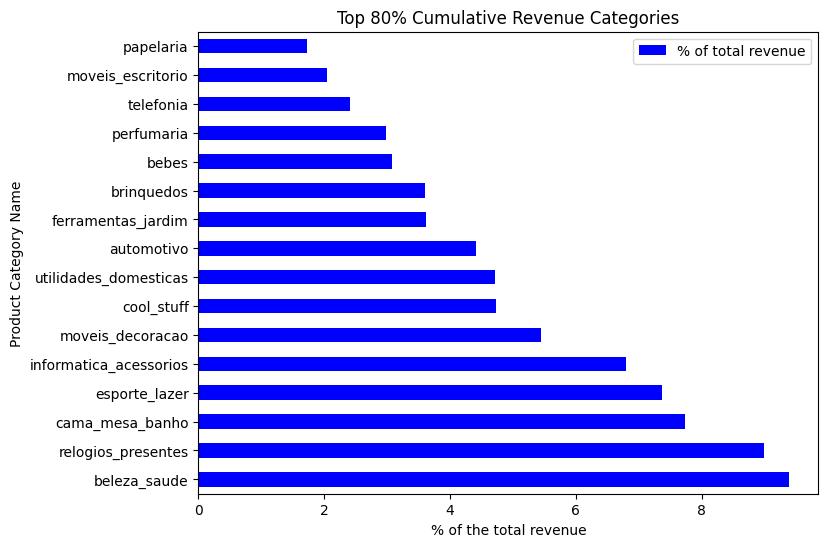

In [13]:
# Plot the filtered Series as a horizontal bar chart
ax = plot_cat.plot(kind='barh', figsize=(8, 6), color='blue')

# Set the chart title and axis labels
ax.set_title('Top 80% Cumulative Revenue Categories')
ax.set_ylabel("Product Category Name")
ax.set_xlabel('% of the total revenue')
ax.legend(labels=['% of total revenue']);

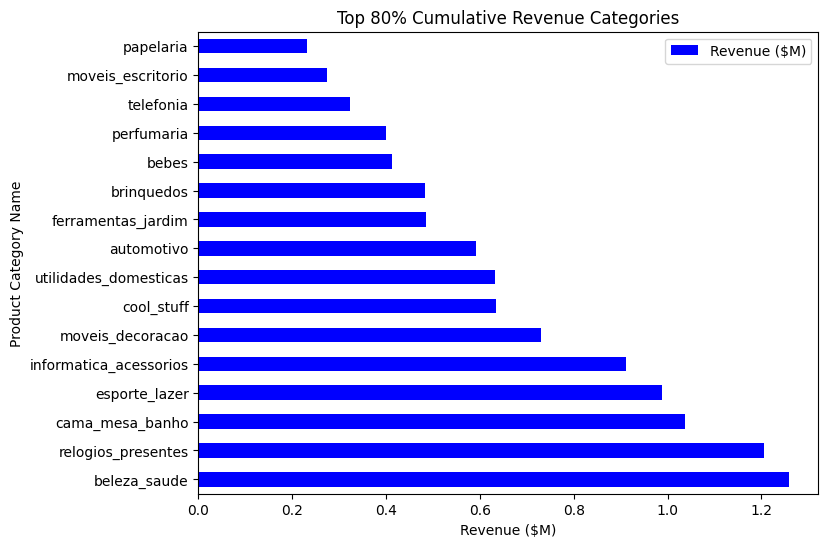

In [14]:
# Plot the filtered Series as a horizontal bar chart
ax = cat_top.loc[top_80pct].plot(kind='barh', figsize=(8, 6), color='blue')

# Set the chart title and axis labels
ax.set_title('Top 80% Cumulative Revenue Categories')
ax.set_ylabel("Product Category Name")
ax.set_xlabel('Revenue ($M)')
# Disable scientific notation on the x-axis label
ax.xaxis.offsetText.set_visible(False)
ax.legend(labels=['Revenue ($M)']);

# Pareto principle

In [15]:
print(f"As to confirm the pareto principle, it was possible to notice that {round((len(top_80pct) / len(cat_top))*100, 2)} % of all product categories generated {round(plot_cat.sum()[0], 2)} % of the total revenue.")

As to confirm the pareto principle, it was possible to notice that 21.92 % of all product categories generated 79.03 % of the total revenue.


# Sales forecast

So, let's focus on the top 80% revenue product categories and analyse their sales trough time.

In [16]:
df_purch.keys()

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm'],
      dtype='object')

In [17]:
df_forecast = df_purch[df_purch["product_category_name"].isin(top_80pct)][['order_approved_at', 'product_category_name', 'price']].dropna().set_index("order_approved_at").sort_index()
df_forecast

,product_category_name,price
order_approved_at,,
2016-09-15 12:16:38,beleza_saude,44.99
2016-09-15 12:16:38,beleza_saude,44.99
2016-09-15 12:16:38,beleza_saude,44.99
2016-10-04 10:18:57,esporte_lazer,21.50
2016-10-04 10:25:46,utilidades_domesticas,89.90
...,...,...
2018-08-29 10:04:16,relogios_presentes,169.80
2018-08-29 10:35:16,esporte_lazer,6.90
2018-08-29 12:35:17,brinquedos,63.90


# Let us plot the top-5 product categories to get a sense of what type of time-series are we dealing with

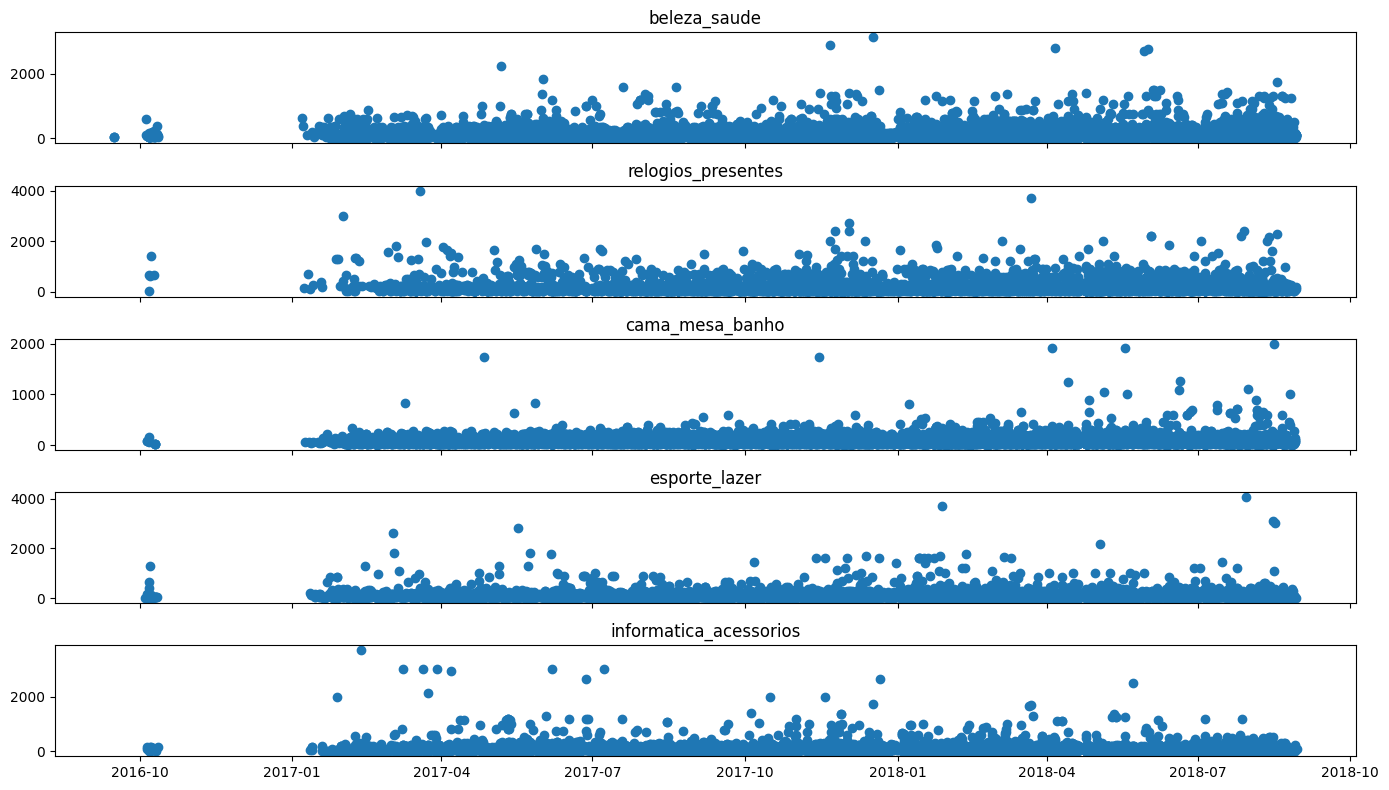

In [18]:
fig, axes = plt.subplots(nrows=5, ncols=1, sharex=True, figsize=(14, 8))

for i, cat in enumerate(top_80pct[0:5]):
    axes[i].scatter(df_forecast[df_forecast["product_category_name"] == cat].index, df_forecast[df_forecast["product_category_name"] == cat]["price"])
    axes[i].set_title(cat)

plt.tight_layout()
plt.show()

It seems that prior to 2017, the data available goes back to first days from October and continues with a gap of new data until first days of 2017. Considering that, it is reasonable to drop data before 2017.

In [19]:
df_forecast = df_forecast[df_forecast.index >= "2017-01-01"].resample("D").sum()
df_forecast

C:\Users\rafae\AppData\Local\Temp\ipykernel_8952\3696863509.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_forecast = df_forecast[df_forecast.index >= "2017-01-01"].resample("D").sum()


,price
order_approved_at,
2017-01-05,65.00
2017-01-06,795.99
2017-01-07,1450.20
2017-01-08,328.70
2017-01-09,776.79
...,...
2018-08-25,7525.62
2018-08-26,6285.66
2018-08-27,4703.49


Now let us go ahead and plot the sum of top-5 product categories sales considering different resample times: daily, weekly and monthly.

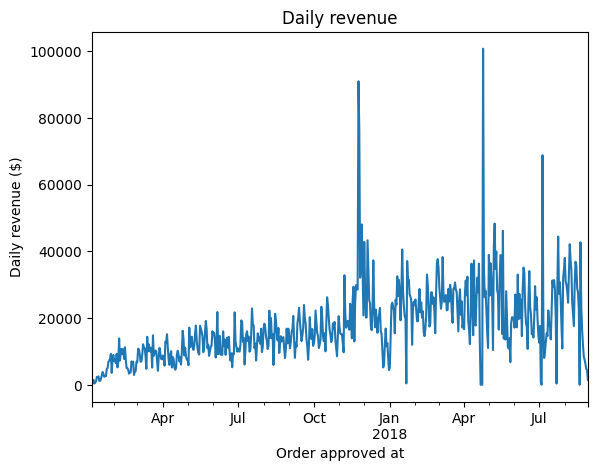

In [20]:
# plotting daily revenue
df_forecast["price"].resample("D").sum().plot(title="Daily revenue")
plt.xlabel("Order approved at")
plt.ylabel("Daily revenue ($)");

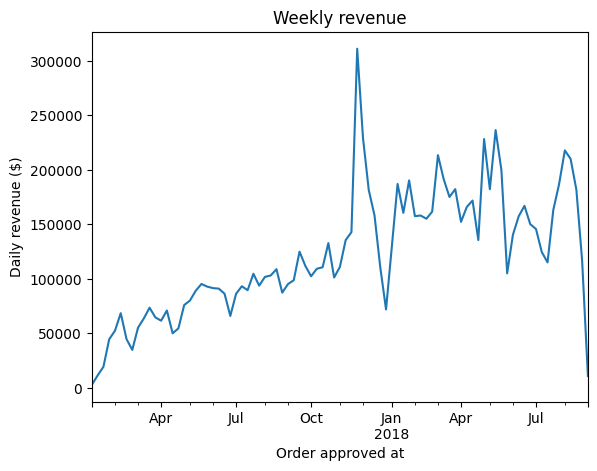

In [21]:
# plotting weekly revenue
df_forecast["price"].resample("W").sum().plot(title="Weekly revenue")
plt.xlabel("Order approved at")
plt.ylabel("Daily revenue ($)");

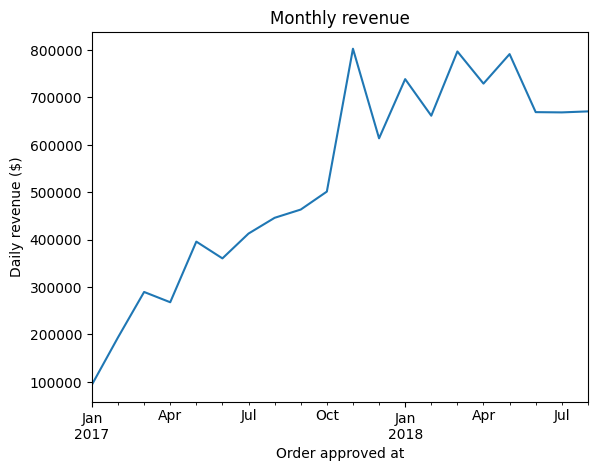

In [22]:
# plotting monthly revenue
df_forecast["price"].resample("M").sum().plot(title="Monthly revenue")
plt.xlabel("Order approved at")
plt.ylabel("Daily revenue ($)");

# Feature Creation

In [23]:
print(f"Important to highlight that we only have 2017 as a full year of data and 2018 data ends at: {df_forecast.index[-1].strftime('%Y-%m-%d')}.")

Important to highlight that we only have 2017 as a full year of data and 2018 data ends at: 2018-08-29.


In [24]:
def create_features(df):
    '''
    Create time series based on time series index.
    '''
    df = df.copy()
    df.loc[:, "dayofweek"] = df.index.dayofweek
    df.loc[:, "day"] = df.index.day
    df.loc[:, "weekyear"] = df.index.weekofyear
    df.loc[:, "month"] = df.index.month
    df.loc[:, "quarter"] = df.index.quarter
    df.loc[:, "year"] = df.index.year
    df.loc[:, "dayofyear"] = df.index.dayofyear
    
    return df

In [25]:
df_forecast = create_features(df_forecast)

C:\Users\rafae\AppData\Local\Temp\ipykernel_8952\2864077082.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df.loc[:, "weekyear"] = df.index.weekofyear


# Visualizing our Feature / Target relationship

In [26]:
# selecting data for plot visualizations, excluded outliers > than 0.95 percentile
plot_viz = df_forecast[df_forecast["price"] < df_forecast["price"].quantile(0.95)]
plot_viz

,price,dayofweek,day,weekyear,month,quarter,year,dayofyear
order_approved_at,,,,,,,,
2017-01-05,65.00,3,5,1,1,1,2017,5
2017-01-06,795.99,4,6,1,1,1,2017,6
2017-01-07,1450.20,5,7,1,1,1,2017,7
2017-01-08,328.70,6,8,1,1,1,2017,8
2017-01-09,776.79,0,9,2,1,1,2017,9
...,...,...,...,...,...,...,...,...
2018-08-25,7525.62,5,25,34,8,3,2018,237
2018-08-26,6285.66,6,26,34,8,3,2018,238
2018-08-27,4703.49,0,27,35,8,3,2018,239


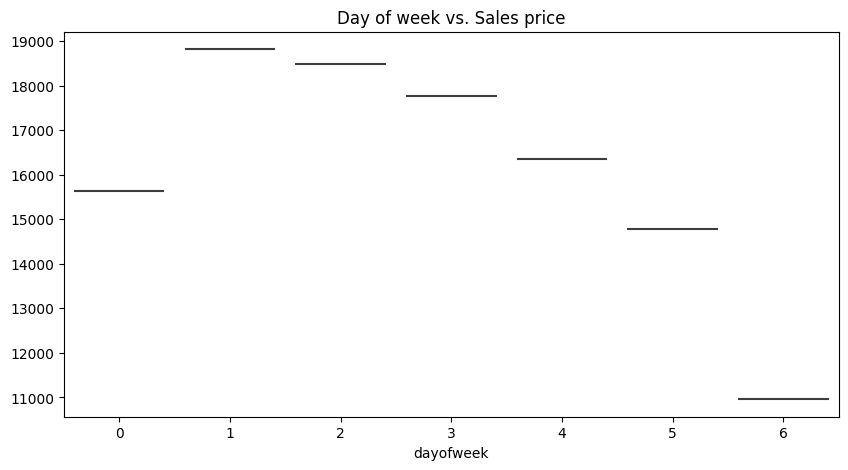

In [27]:
# barplot of dayofweek vs. mean sales price. PS: 0 being Monday all the way to 6 being Sunday.
plt.figure(figsize=(10,5))
sns.violinplot(x=plot_viz.groupby("dayofweek").mean()["price"].index, y=plot_viz.groupby("dayofweek").mean()["price"].values)
plt.title("Day of week vs. Sales price");

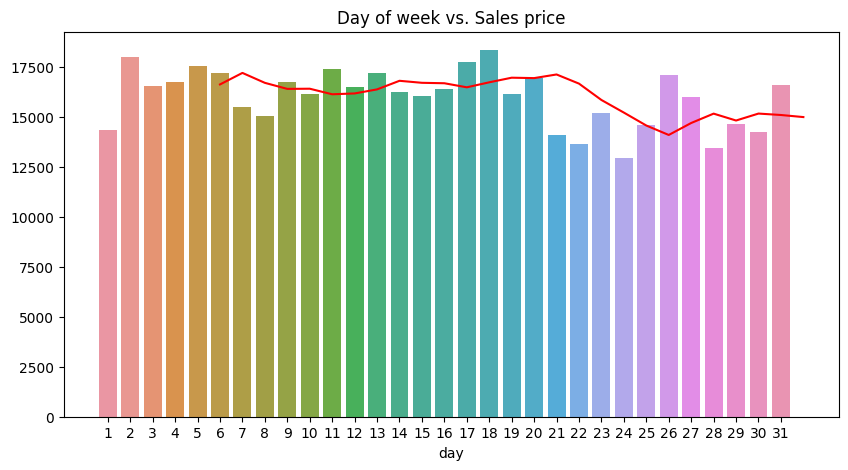

In [28]:
# barplot of month days vs. mean sales price.
plt.figure(figsize=(10,5))
sns.barplot(x=plot_viz.groupby("day").mean()["price"].index, y=plot_viz.groupby("day").mean()["price"].values)
plt.plot(plot_viz.groupby("day").mean()["price"].rolling(5).mean(), color="red")
plt.title("Day of week vs. Sales price");

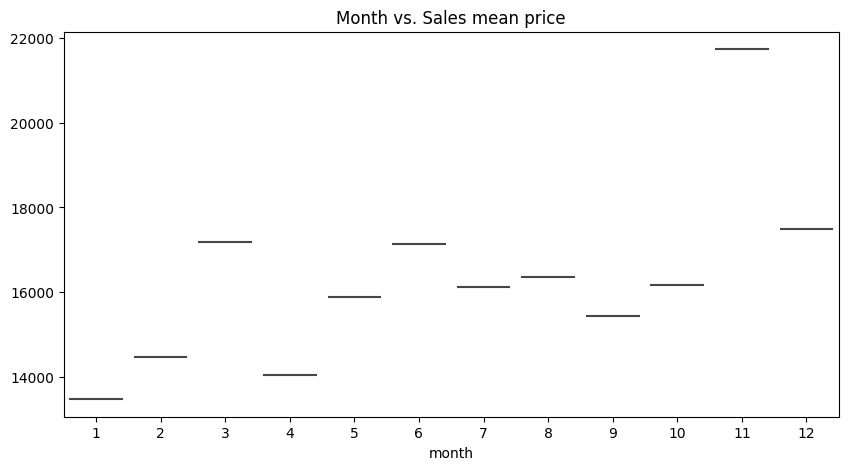

In [29]:
# barplot of month vs. mean sales price.
plt.figure(figsize=(10,5))
sns.violinplot(x=plot_viz.groupby("month").mean()["price"].index, y=plot_viz.groupby("month").mean()["price"].values)
plt.title("Month vs. Sales mean price");

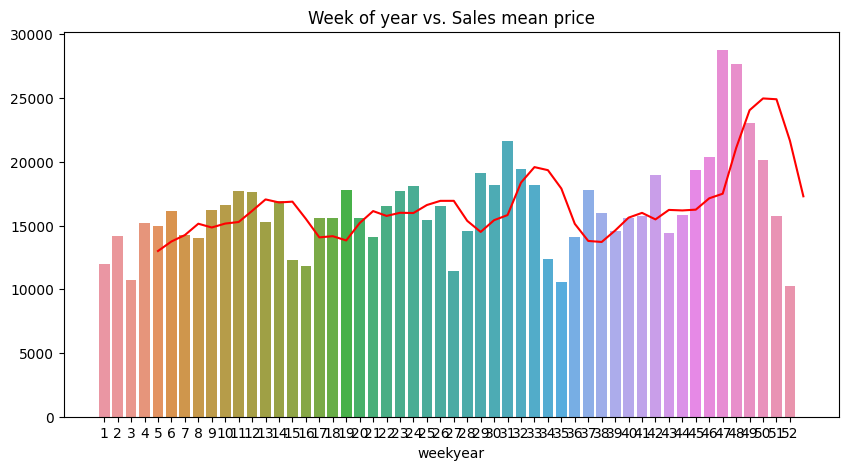

In [30]:
# barplot of weekyear vs. mean sales price.
plt.figure(figsize=(10,5))
sns.barplot(x=plot_viz.groupby("weekyear").mean()["price"].index, y=plot_viz.groupby("weekyear").mean()["price"].values)
plt.plot(plot_viz.groupby("weekyear").mean()["price"].rolling(4).mean(), color="red")
plt.title("Week of year vs. Sales mean price");

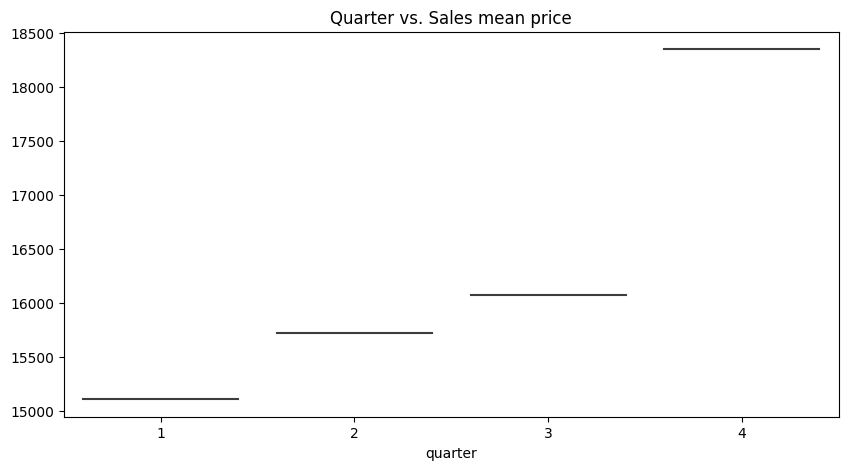

In [31]:
# barplot of month vs. mean sales price.
plt.figure(figsize=(10,5))
sns.violinplot(x=plot_viz.groupby("quarter").mean()["price"].index, y=plot_viz.groupby("quarter").mean()["price"].values)
plt.title("Quarter vs. Sales mean price");

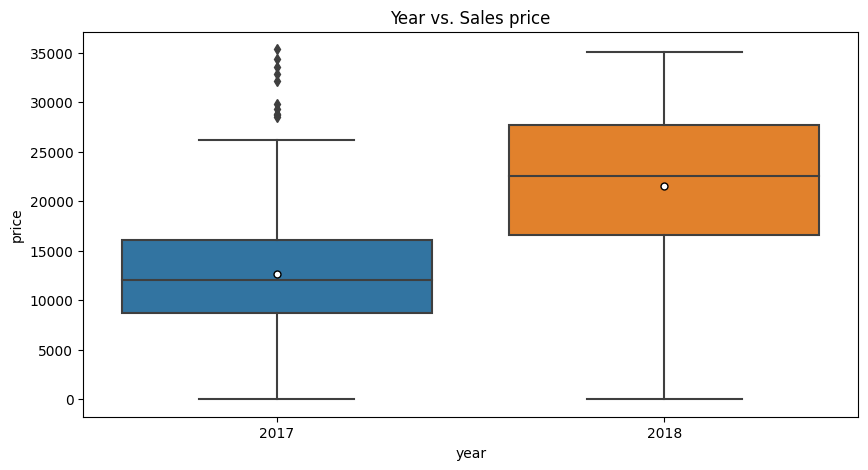

In [32]:
# boxplot of year vs. sales price.
# excluded outliers > than 0.95 percentile
plt.figure(figsize=(10,5))
sns.boxplot(data=df_forecast[df_forecast["price"] < df_forecast["price"].quantile(0.95)], x="year", y="price", showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
plt.title("Year vs. Sales price");

# Main caveats from the plots:
- Monday and Sunday are the most important weekdays for the business
- First days of the month tend to have higher sales revenue, gradually falling as month goes by.
- Months 4, 9 and 12 have the higher mean revenues.
- Week 34 weirdly weak for business
- Quarters 2 and 4 are stronger than 1 and 3

# Training and Test data split

In [33]:
# assuming train set have 90% of the data and test set have 10% of the data
train_size = int(round(0.9*len(df_forecast)))
test_size = int(round(0.1*len(df_forecast)))
print(f"Days of whole dataset: {len(df_forecast)}.")
print(f"Days of train set: {train_size}.")
print(f"Days of test set: {test_size}.")

Days of whole dataset: 602.
Days of train set: 542.
Days of test set: 60.


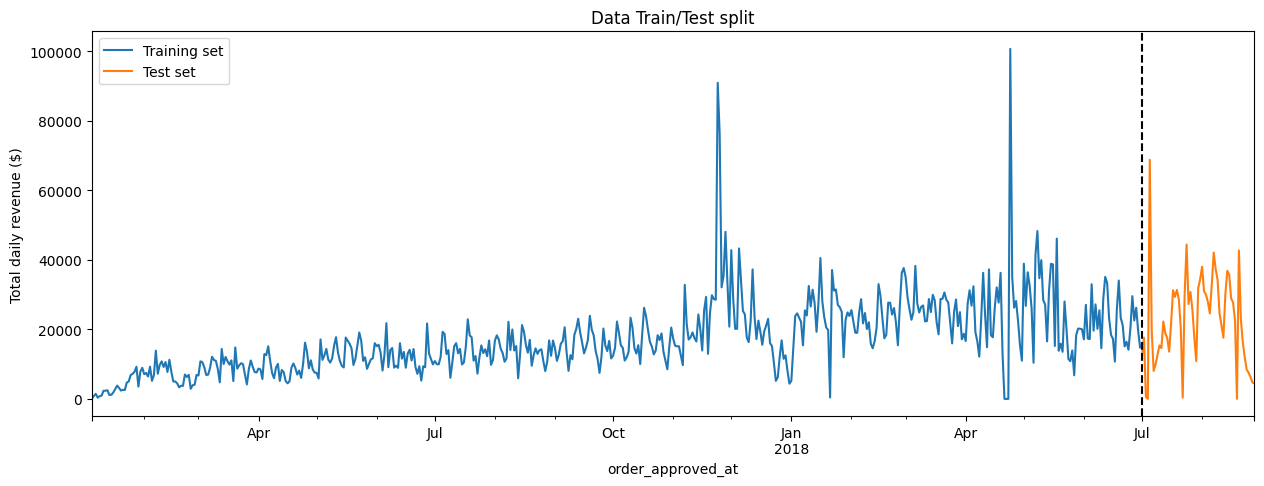

In [34]:
train = df_forecast.iloc[0:train_size, :]
test = df_forecast.iloc[train_size: -1, :]

fig, ax = plt.subplots(figsize=(15, 5))
train["price"].plot(ax=ax, label = "Training set", title="Data Train/Test split", ylabel="Total daily revenue ($)")
test["price"].plot(ax=ax, label = "Test set")
ax.legend(["Training set", "Test set"])
ax.axvline(df_forecast.iloc[train_size, :].name, color="black", ls="--");

# Create our model

In [35]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rouns=50)

In [36]:
features = ['dayofweek', 'day', 'weekyear', 'month', 'quarter', 'year', 'dayofyear']
target = 'price'

In [37]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [38]:
reg.fit(
    X_train, y_train,
    eval_set = [(X_train, y_train), (X_test, y_test)],
    verbose=100
)

[17:39:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "early_stopping_rouns" } are not used.

[0]	validation_0-rmse:14789.24312	validation_1-rmse:20797.97580
[100]	validation_0-rmse:480.92495	validation_1-rmse:11912.07643
[200]	validation_0-rmse:100.43315	validation_1-rmse:11915.57185
[300]	validation_0-rmse:24.20167	validation_1-rmse:11905.15608
[400]	validation_0-rmse:7.18062	validation_1-rmse:11901.96923
[500]	validation_0-rmse:1.98160	validation_1-rmse:11901.46097
[600]	validation_0-rmse:0.57970	validation_1-rmse:11901.39328
[700]	validation_0-rmse:0.19063	validation_1-rmse:11901.35635
[800]	validation_0-rmse:0.05288	validation_1-rmse:11901.36259
[900]	validation_0-rmse:0.01332	validation_1-rmse:11901.36597
[999]	validation_0-rmse:0.00594	validation_1-rmse:11901.36485


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             early_stopping_rouns=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

# Featue importances

In [39]:
fi = pd.DataFrame(data = reg.feature_importances_, index=reg.feature_names_in_, columns=["Importance"])

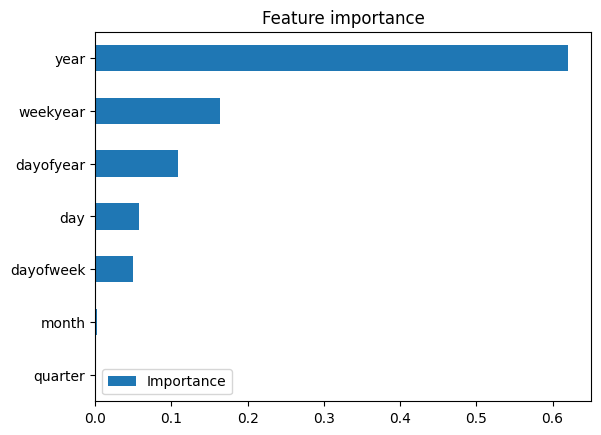

In [40]:
fi.sort_values("Importance").plot(kind="barh", title="Feature importance");

# Forecast on Test set

In [41]:
test["prediction"] = np.round(reg.predict(X_test), 2)
test

C:\Users\rafae\AppData\Local\Temp\ipykernel_8952\4165546725.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["prediction"] = np.round(reg.predict(X_test), 2)


,price,dayofweek,day,weekyear,month,quarter,year,dayofyear,prediction
order_approved_at,,,,,,,,,
2018-07-01,12598.71,6,1,26,7,3,2018,182,12933.570312
2018-07-02,17594.11,0,2,27,7,3,2018,183,24714.130859
2018-07-03,535.58,1,3,27,7,3,2018,184,30440.369141
2018-07-04,0.00,2,4,27,7,3,2018,185,24078.570312
2018-07-05,68766.47,3,5,27,7,3,2018,186,27084.359375
2018-07-06,19540.87,4,6,27,7,3,2018,187,20274.269531
2018-07-07,8037.96,5,7,27,7,3,2018,188,16501.650391
2018-07-08,9985.55,6,8,27,7,3,2018,189,12023.259766
2018-07-09,12676.67,0,9,28,7,3,2018,190,26745.189453


In [42]:
df_forecast = df_forecast.merge(test[["prediction"]], how="left", left_index=True, right_index=True)

In [43]:
df_forecast

,price,dayofweek,day,weekyear,month,quarter,year,dayofyear,prediction
order_approved_at,,,,,,,,,
2017-01-05,65.00,3,5,1,1,1,2017,5,NaN
2017-01-06,795.99,4,6,1,1,1,2017,6,NaN
2017-01-07,1450.20,5,7,1,1,1,2017,7,NaN
2017-01-08,328.70,6,8,1,1,1,2017,8,NaN
2017-01-09,776.79,0,9,2,1,1,2017,9,NaN
...,...,...,...,...,...,...,...,...,...
2018-08-25,7525.62,5,25,34,8,3,2018,237,16752.480469
2018-08-26,6285.66,6,26,34,8,3,2018,238,10111.480469
2018-08-27,4703.49,0,27,35,8,3,2018,239,19147.589844


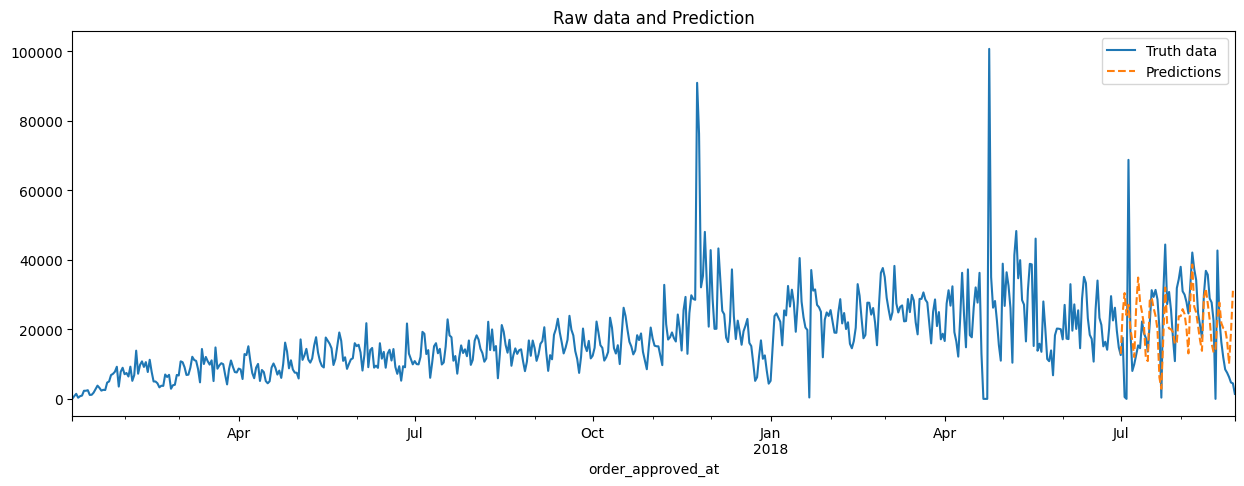

In [44]:
ax = df_forecast[["price"]].plot(figsize=(15, 5))
df_forecast["prediction"].plot(ax=ax, style="--")
plt.legend(["Truth data", "Predictions"])
ax.set_title("Raw data and Prediction")
plt.show()

# Let us look at one month prediction vs. real data

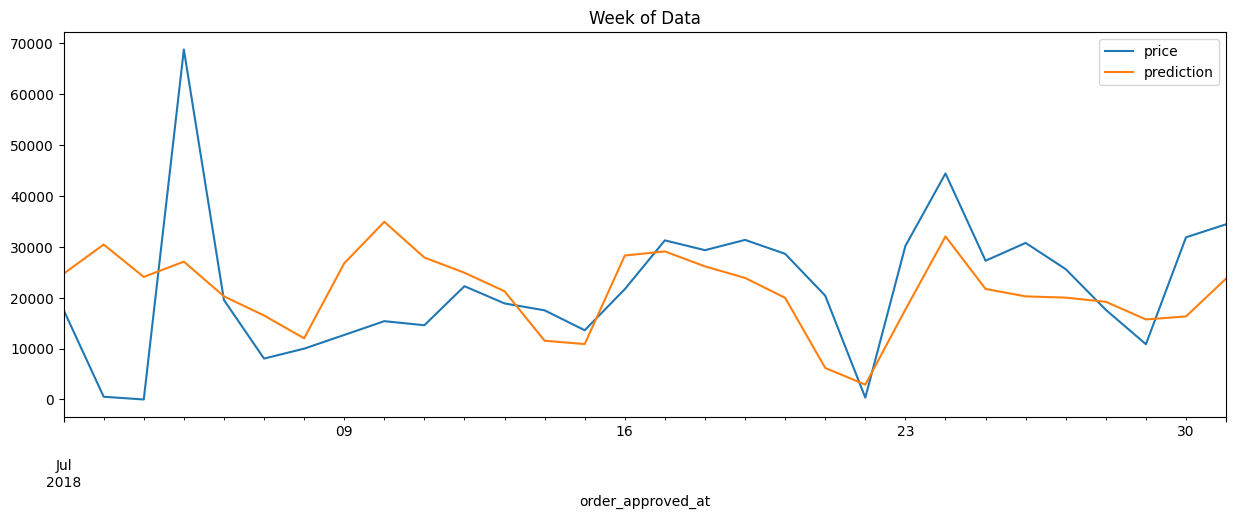

In [45]:
df_forecast[["price", "prediction"]].loc[
    (df_forecast[["price", "prediction"]].index > "2018-07-01") & (df_forecast[["price", "prediction"]].index < "2018-08-01")
].plot(figsize=(15, 5), title="Week of Data")
plt.show()

# Calculate Error
- Look at the worst and best predicted days

In [46]:
test["error"] = np.abs(test[target] - test["prediction"])

In [47]:
test["error"].sort_values(ascending=False).head(10)

order_approved_at
2018-07-05    41682.110625
2018-07-03    29904.789141
2018-08-28    26626.289922
2018-07-04    24078.570312
2018-07-10    19522.488750
2018-08-20    19488.570547
2018-07-30    15539.660469
2018-08-27    14444.099844
2018-08-19    14387.490234
2018-07-21    14204.200215
Name: error, dtype: float64

In [48]:
test["error"].sort_values(ascending=True).head(10)

order_approved_at
2018-07-01     334.860313
2018-07-06     733.399531
2018-08-13     985.219844
2018-07-28    1577.360078
2018-07-08    2037.709766
2018-07-17    2173.829375
2018-07-13    2392.879141
2018-07-22    2567.600039
2018-07-12    2645.689844
2018-07-15    2709.999570
Name: error, dtype: float64

# Next steps
- More robust cross validation
- Add more features